<a href="https://colab.research.google.com/github/soumyadip1995/Uber-Ludwig/blob/master/Uber_Ludwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://cdn-images-1.medium.com/max/750/1*IrwMuRkv6s9_mZib4pMRCg.png)


#Introduction

Uber continues its spree of deep learning technology releases. Since last year, the Uber AI Labs team has open sourced different frameworks that enable many of the fundamental building blocks of deep learning solutions. In February of this year Uber AI labs came up with a deep learning toolbox named Ludwig. This is a toolbox for training deep learning models without writing any kind of code.

Training is one of the most developer intensive aspects of deep learning applications. Typically, data scientists spend numerous hours experimenting with different deep learning models to better perform about a specific training datasets. This process involves more than just training including several other aspects such as model comparison, evaluation, workload distribution and many others. Simplifying the training processes is the number one factor that can streamline the experimentation phase in deep learning solutions.


##What is Ludwig ?


Ludwig is a TensorFlow based toolbox that allows to train and test deep learning models without the need to write code. Incubated at Uber for the last two years, Ludwig was finally open sourced to incorporate the contributions of the data science community. Conceptually, Ludwig was created under five fundamental principles:

**1. No coding required**: no coding skills are required to train a model and use it for obtaining predictions.

**2. Generality**: a new data type-based approach to deep learning model design that makes the tool usable across many different use cases.

**3. Flexibility**: experienced users have extensive control over model building and training, while newcomers will find it easy to use.

**4. Extensibility**: easy to add new model architecture and new feature data types.

**5. Understandability**: deep learning model internals are often considered black boxes, but we provide standard visualizations to understand their performance and compare their predictions.



This post contains the following:

1. Ludwig model Architecture
2. Injecting prior knowledge in the Architecture
3. Summary of the Architecture
4. Ludwig in Action
5. Closing Summary





All you need to provide is a CSV file containing your data, a list of columns to use as inputs, and a list of columns to use as outputs, Ludwig will do the rest. Simple commands can be used to train models both locally and in a distributed way, and to use them to predict on new data.


Ludwig allows its users to train a deep learning model by providing just a tabular file (like CSV) containing the data and a YAML configuration file that specifies which columns of the tabular file are input features and which are output target variables. The simplicity of the configuration file enables faster prototyping, potentially reducing hours of coding down to a few minutes. If more than one output target variable is specified, Ludwig will perform** multi-task learning**, learning to predict all the outputs simultaneously, a task that usually requires custom code.


#The Ludwig model Architecture

The main new idea that Ludwig introduces is the notion of data type-specific encoders and decoders, which results in a highly modularized and extensible architecture: each type of data supported (text, images, categories, and so on) has a specific preprocessing function. In short, encoders map the raw data to tensors, and decoders map tensors to the raw data.The model definition can contain additional information, in particular preprocessing information for each feature in the dataset, which encoder or decoder to use for each feature, architectural parameters for each encoder and decoder, and training parameters. Ludwig uses a type of model called the** Encoder- Combiner-Decoder model**. Encoder-Combiner-Decoder is a novel deep learning architecture that allows for heterogeneous input and output types and the** injection of prior knowledge** in the
form of architecture choices.

##Encoder -Combiner- Decoder model


The combination of deep-and-wide with multi-task learning inspired losses forms the basis of a new general architecture , the Encoder-Combiner-Decoder (ECD), depicted in the figure below.


##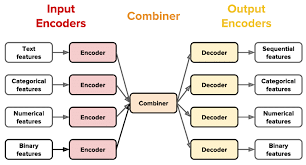


### The Encoder part 

In the encoder part of the architecture, each single input feature is encoded by a sub-part of the model, depending on its type. 














More formally each encoder is a function:-




##$_{et(ϕi (x))}(ϕi(x))$ 









where  $ϕi(x)$  is the i-th input feature and  $t(ϕ(x))$ is the type of feature.



For instance, text features can by encoded by a Character-Based
CNN or by a Bidirectional RNN on the word sequence, categorical
features can be encoded through a linear projection into an embedding space, binary feature can be encoded with one single number and numerical features can be encoded through a single neuron
that acts as a learned scaling factor. Each of these different encoders outputs a vector encoding for the input feature they deal with.


### The Combiner Part





In the combiner part, those vectors are concatenated as they are in
the wide-and-deep approach, but the concatenation is optionally
followed by fully connected layers that can learn some non-linear
combination of the representations obtained so far. The combiner
is needed in any circumstance when there is more than one input
feature, like in this case, but could be skipped if there’s more there
is only one input feature(see the figure above). A combiner is defined as a function c(x)
so that:




##$$c(x) = f ([_{et(ϕ_{0}(x))}(ϕ_{0}(x)), . . . ,_{et(ϕ_{n}(x))}(ϕ_{n}(x))])$$




where [...] is the concatenation operator, n is the number of input
features, and f is a multi-layer perceptron.

###The Decoder Part

Finally, in the decoder part, different output features have different “heads”, with each of them predicting a different output feature depending on their type. Each output decoder can contain an arbitrary number of additional fully connected layers between the output of the combiner and the
layer responsible for the prediction. This makes it possible to have a multi-task model with weights shared among all the tasks up to the combiner and have a set of weights that are task-specific for
increased flexibility. Each decoder is a function d that returns a loss
and is defined as:-


##$$d_{ϕi (x)}(x) = f_{ϕi (x)}(c(x))$$




where*** f*** is again a multi layer perceptron and there could be different * fs * for different output features. 

###The Output Features

Categorical output features
are treated as a multi-class classification task: they use the output
of the combiner and pass it through softmax layer, and return a
categorical cross entropy loss. Numeric output features are treated
as a regression task: they use the output of the combiner to predict
a single value, and return a mean squared error loss. Binary output
features are treated as a binary classification task: they use the output of the combiner as input for a layer with a activation, and return a cross entropy loss. The sum of all the losses coming from the different output features is optimized through any variant of stochastic gradient descent in multi-task learning fashion.

##$$L(x) =\sum_{i ∈o(x)}w_{i}d_{ϕi (x)}(x)$$


where $o(x)$ is the set of indices of output features, and $w_{i}$
is a user
defined weight for the specific output feature.

The ECD architecture provides **three key benefits**. 




1.   It directly incorporates all raw input features, eschewing the need for preprocessing outside of                 mapping textual and categorical features into integers, as well as learning a single model to predict         both contact types and reply templates.

2.   Finally, the architecture enables an easy method for swapping and comparing different encoders.


3. Each of them can be parametrized independently, specifying the number of layers, the size of convolutional filters of each layer and how many stacked RNNs to use.

##Injecting Prior Knowlege into the Architecture


The ECD architecture makes it possible to further improve model
performance by injecting prior knowledge about each task directly
at the model architecture level. This can bre done by, the following:-


 ### *** 1. Predicting paths in a tree***
 
 
Using a tree and predicting a path in the tree that leads to the target output
rather than predicting the output directly. Luckily for us, the architecture is already in a hierarchial format, so this makes it easy.We can put the entire Hierarchy in a tree and predict the target output.


###*** 2. Adding decoder dependencies***


As different decoders can have a set of weights that is specific to
output feature they try to predict, the output of the decoder is injected as an additional input, concatenating it with the output of the combiner(see the figure above). More
generally,  the ECD architecture allows for dependencies between
output features. The dependencies must form a directed acyclic
graph for the computational graph to be built as when building
it the outputs of the decoders of all the output features that the
current output feature is dependent on is concatenated with the
output of the combiner.



The hypothesis is that adding dependencies among output features would help in the overall performance in predicting output features with dependencies should improve due to to the prior knowledge injection.




##Summary of the Architecture


Each data type may have more than one encoder and decoder. For instance, text can be encoded with a convolutional neural network (CNN), a recurrent neural network (RNN), or other encoders. The user can then specify which one to use and its hyperparameters directly in the model definition file without having to write a single line of code.

This versatile and flexible encoder-decoder architecture makes it easy for less experienced deep learning practitioners to train models for diverse machine learning tasks, such as text classification, object classification, image captioning, sequence tagging, regression, language modeling, machine translation, time series forecasting, and question answering. This opens up a variety of use cases that would typically be out of reach for inexperienced practitioners, and allows users experienced in one domain to approach new domains


##Ludwig in Action

Data scientists will use Ludwig for two main functionalities: training and predictions. Suppose that we are working on a text classification scenario with the following dataset:-



![alt text](https://cdn-images-1.medium.com/max/750/1*UuS_PhoB9O7cm6VERzf8eg.png)


We can get started with Ludwig by installing it using the following command:

In [0]:
!pip install ludwig
python -m spacy download en


The next step would be to configure a model definition YAML file that specifies the input and output features of the model

In [0]:

input_features:
    -
        name: text
        type: text
        encoder: parallel_cnn
        level: word

output_features:
    -
        name: class
        type: category

With those two inputs(training data and YAML configuration), we can train a deep learning model using the following command

In [0]:
ludwig experiment \
  --data_csv reuters-allcats.csv \
  --model_definition_file model_definition.yaml

Ludwig provides a series of visualizations that can be used during training and predictions. For instance, the learning curve visualization give us an idea of the training and testing performance of the model. (Ludwig)


![alt text](https://cdn-images-1.medium.com/max/938/1*l8QRBL6MB1yiwjOmQ0dX1Q.png)

 These learning curves show loss and accuracy over training epochs.


After training we can evaluate the predictions of the model using the following command:



In [0]:
ludwig predict --data_csv path/to/data.csv --model_path /path/to/model

Other visualizations can be used to evaluate the performance of the model. (Source: Ludwig)


![alt_text](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/image1-768x528.png)



The complete Ludwig feature set is programmatically available via APIs. Recreating our example using Python is a matter of a few lines of code:




In [0]:
from ludwig import LudwigModel

# train a model
model_definition = {...}
model = LudwigModel(model_definition)
train_stats = model.train(training_dataframe)

# or load a model
model = LudwigModel.load(model_path)

# obtain predictions
predictions = model.predict(test_dataframe)

model.close()

Despite its robust capabilities, Ludwig provides a very extensible architecture for data scientists to incorporate their own encoders and decoders as well as functions to pre-process the data. For instance, creating a new Ludwig encoder is a matter of implementing the init and call methods as shown in the following code:


In [0]:
def __init__(
    self,
    should_embed=True,
    vocab=None,
    representation='dense',
    embedding_size=256,
    embeddings_trainable=True,
    pretrained_embeddings=None,
    embeddings_on_cpu=False,
    num_layers=1,
    state_size=256,
    cell_type='rnn',
    bidirectional=False,
    dropout=False,
    initializer=None,
    regularize=True,
    reduce_output='last',
    **kwargs
):
__call__(
    self,
    input_placeholder,
    regularizer,
    dropout,
    is_training
)


## Closing Summary


1. Ludwig is an incredibly helpful toolbox for the training and experimentation of deep learning models.

2. Using Ludwig will allow even junior data scientists to train and test highly sophisticated deep learning     models without the need of writing any code.

3. Ludwig provides a very extensible architecture for data scientists to incorporate their own encoders    and decoders as well as functions to pre-process the data.

4. Ludwig’s simple training and interactive visualization processes can drastically shorten the experimentation cycles in deep learning applications allowing experts to focus on fine tuning the architecture of the target models instead of spending countless hours doing repetitive training work.







